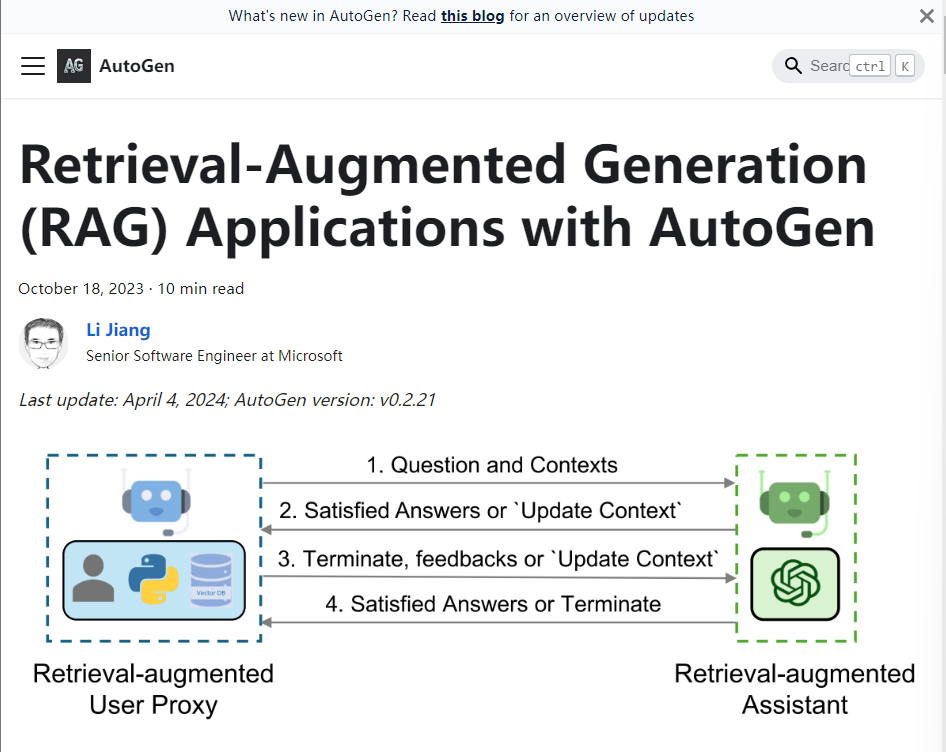

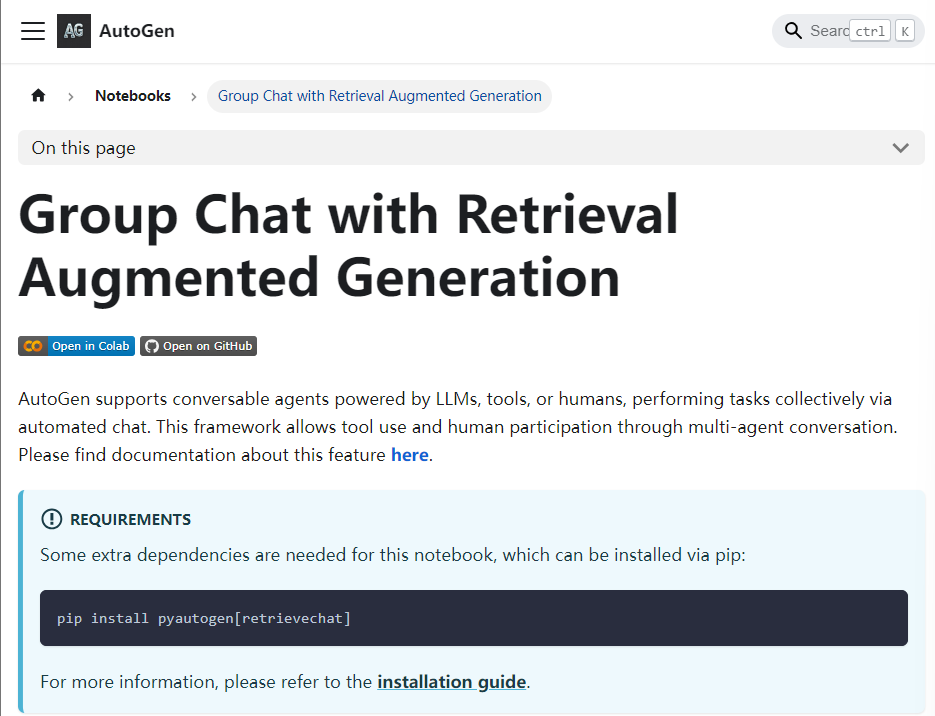

https://microsoft.github.io/autogen/blog/2023/10/18/RetrieveChat/
https://microsoft.github.io/autogen/docs/notebooks/agentchat_groupchat_RAG/

setup model

In [10]:
pip install pyautogen[retrievechat]

Note: you may need to restart the kernel to use updated packages.


In [2]:
import chromadb
from typing_extensions import Annotated
import autogen
from autogen import AssistantAgent
from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent

In [3]:
mistral = {
    "config_list": [
        {
            "model": "TheBloke/Mistral-7B-Instruct-v0.2-GGUF",
            "base_url": "http://localhost:1234/v1",
            "api_key": "lm-studio",
        },
    ],
    "cache_seed": None,  # Disable caching.
}

config_list = mistral

print("LLM models: ", mistral)

LLM models:  {'config_list': [{'model': 'TheBloke/Mistral-7B-Instruct-v0.2-GGUF', 'base_url': 'http://localhost:1234/v1', 'api_key': 'lm-studio'}], 'cache_seed': None}


In [4]:
llm_config = {"config_list": config_list, "timeout": 60, "temperature": 0.8, "seed": 1234}

In [13]:
def _reset_agents():
    boss.reset()
    boss_aid.reset()
    coder.reset()
    reviewer.reset()
    Internal_Auditor.reset()
    Accountant.reset()

In [14]:
def termination_msg(x):
    return isinstance(x, dict) and "TERMINATE" == str(x.get("content", ""))[-9:].upper()

convert pdf to md for next processing

In [68]:
pip install requests PyPDF2


  Using cached pypdf2-3.0.1-py3-none-any.whl.metadata (6.8 kB)
Using cached pypdf2-3.0.1-py3-none-any.whl (232 kB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import requests
from PyPDF2 import PdfReader
from io import BytesIO

def download_pdf(url):
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful
    return BytesIO(response.content)

def extract_text_from_pdf(pdf_file):
    reader = PdfReader(pdf_file)
    text = []
    for page in reader.pages:
        text.append(page.extract_text())
    return "\n".join(text)

def save_text_to_file(text, filename):
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(text)

def main():
    url = "https://jabatanfungsionalauditor.wordpress.com/wp-content/uploads/2016/06/the-internal-auditing-handbook-k-h-spencer-pickett-2010.pdf"
    pdf_file = download_pdf(url)
    text = extract_text_from_pdf(pdf_file)
    
    # Get the default directory
    default_dir = os.getcwd()
    output_path = os.path.join(default_dir, 'internal_auditing_handbook.md')
    
    save_text_to_file(text, output_path)
    print(f"Text extracted and saved to {output_path}")

if __name__ == "__main__":
    main()


Text extracted and saved to e:\Daily_Coding\20240430 autogen\internal_auditing_handbook.md


defining roles

In [15]:
# all roles

boss = autogen.UserProxyAgent(
    name="Boss",
#    is_termination_msg=termination_msg,
    human_input_mode="NEVER",
    code_execution_config=False,  # we don't want to execute code in this case.
    default_auto_reply="Go on with the discussion. Reply `TERMINATE` if the task is done and confirmed by everyone.",
    description="The boss who ask questions and give tasks.",
)

boss_aid = RetrieveUserProxyAgent(
    name="Boss_Assistant",
    default_auto_reply="working on the current task",
#    max_consecutive_auto_reply=10,
    retrieve_config={
        "task": "default",
        "docs_path": "internal_auditing_handbook.md",
        "chunk_token_size": 1000,
        "model": "mistral",
        "collection_name": "groupchat",
        "get_or_create": True,
    },
    code_execution_config=False,  # we don't want to execute code in this case.
    description="Assistant who has extra content retrieval power for solving difficult problems.",
)

'''
boss_aid = RetrieveUserProxyAgent(
    name="Boss_Assistant",
#    is_termination_msg=termination_msg,
    human_input_mode="NEVER",
    default_auto_reply="Confirm when your work is done. Reply `TERMINATE` in the end when everything is done and everyone confirms.",
    max_consecutive_auto_reply=10,
    retrieve_config={
        "task": "analyze",
 #      "docs_path": "https://jabatanfungsionalauditor.wordpress.com/wp-content/uploads/2016/06/the-internal-auditing-handbook-k-h-spencer-pickett-2010.pdf",
        "docs_path": "internal_auditing_handbook.md",
        "chunk_token_size": 100,
        "model": "mistral",
        "collection_name": "groupchat",
        "get_or_create": True,
    },
    code_execution_config=False,  # we don't want to execute code in this case.
    description="Assistant who has extra content retrieval power for solving difficult problems.",
)
'''

coder = AssistantAgent(
    name="Senior_Python_Engineer",
    is_termination_msg=termination_msg,
    system_message="You are a senior python engineer, you provide python code to answer questions. Reply `TERMINATE` in the end when everything is done.",
    llm_config=mistral,
    description="Senior Python Engineer who can write code to solve problems and answer questions.",
)

Internal_Auditor = autogen.AssistantAgent(
    name="Internal_Auditor",
#    is_termination_msg=termination_msg,
    system_message="You are a Internal_Auditor. Confirm when your work is done. Reply `TERMINATE` in the end when everything is done and everyone confirms.",
    llm_config=mistral,
    description="Internal_Auditor who can design policy, procedure, and conduct daily internal audit tasks",
)

Accountant = autogen.AssistantAgent(
    name="Internal_Auditor",
#    is_termination_msg=termination_msg,
    system_message="You are a Accountant. Confirm when your work is done. Reply `TERMINATE` in the end when everything is done and everyone confirms.",
    llm_config=mistral,
    description="Internal_Auditor who can make booking and financial report, cooperate with internal auditor according to necessary audit and procedures",
)



reviewer = autogen.AssistantAgent(
    name="Code_Reviewer",
    is_termination_msg=termination_msg,
    system_message="You are a code reviewer. Reply `TERMINATE` in the end when everything is done.",
    llm_config=mistral,
    description="Code Reviewer who can review the code.",
)


In [16]:
PROBLEM = "As a commercial bank, set up internal audit policy, procedure, and regressively check its validity with simulations or senario simulations"

In [30]:
def rag_chat():
    _reset_agents()
    groupchat = autogen.GroupChat(
        agents=[boss_aid, Accountant, Internal_Auditor], 
        messages=[], max_round=3, 
        speaker_selection_method="round_robin",
    )

    llm_config = mistral

    manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)

    # Start chatting with boss_aid as this is the user proxy agent.
    boss_aid.initiate_chat(
        manager,
        message=boss_aid.message_generator,
        problem=PROBLEM,
        n_results=100,
    )

rag_chat()

Model mistral not found. Using cl100k_base encoding.


VectorDB returns doc_ids:  [['fe393d02', '5b3755da', '94bc9cda', '549536ac', '770a1b81', 'f0bbeefc', 'a33b0266', 'be30da7a', 'aa24f800', 'c7d44e39', 'e3a1f679', 'f2ce90db', '9580d173', '4b60413f', '11229137', '6d0482fe', '763e30e7', '63d5b0a7', '3401d02c', '686edf5a', '7189c0a1', 'c307330a', 'a54fa66b', '849b34e6', '4aaebe25', '50dbef55', '739b72dd', '22d54087', '74a97504', '754fa3b5', '2ad3b178', '267fafdb', '7510fd12', '42f85b5b', 'ae13da02', '827064af', '25c254e5', 'fea7b075', '3dd4c0ab', '22b5957e', '6a793c40', '851d7939', 'a85ccb43', '5ab24887', 'f622cae1', '4f85c90d', '165aba9d', 'b4b2c7ad', '218714ce', '18625480', '9e50fa80', 'c4101478', '60962d3f', '3401ad55', '88d564ad', 'bd76abd1', '8440fa16', '69a1ad4e', '3f3e8417', '3eabe5dd', 'f090ac61', '242d1141', 'e370ee79', '7b251b65', '6e83fc20', '0fec9e8c', 'a9bd2a5c', '30f12d7e', '258debb0', 'da5f5a6c', 'd570ec4b', '9305ad98', '0eb9de26', '69a039a3', 'd439c73f', '6f8b67e1', '1f7d5aef', '4d61f88c', 'c4a0d46b', 'c1fdb956', 'd9d8c99d',

Model mistral not found. Using cl100k_base encoding.


Skip doc_id 5b3755da as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 94bc9cda as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 549536ac as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 770a1b81 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id f0bbeefc as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id a33b0266 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id be30da7a as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id aa24f800 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id c7d44e39 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id e3a1f679 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id f2ce90db as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 9580d173 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 4b60413f as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 11229137 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 6d0482fe as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 763e30e7 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Adding content of doc 63d5b0a7 to context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 3401d02c as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 686edf5a as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 7189c0a1 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id c307330a as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id a54fa66b as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 849b34e6 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 4aaebe25 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 50dbef55 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 739b72dd as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 22d54087 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 74a97504 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 754fa3b5 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 2ad3b178 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 267fafdb as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 7510fd12 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 42f85b5b as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id ae13da02 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 827064af as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 25c254e5 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id fea7b075 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 3dd4c0ab as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 22b5957e as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 6a793c40 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 851d7939 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id a85ccb43 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 5ab24887 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id f622cae1 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 4f85c90d as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 165aba9d as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id b4b2c7ad as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 218714ce as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 18625480 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 9e50fa80 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id c4101478 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 60962d3f as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 3401ad55 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 88d564ad as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id bd76abd1 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 8440fa16 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 69a1ad4e as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 3f3e8417 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 3eabe5dd as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id f090ac61 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 242d1141 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id e370ee79 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 7b251b65 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 6e83fc20 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 0fec9e8c as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id a9bd2a5c as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 30f12d7e as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 258debb0 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id da5f5a6c as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id d570ec4b as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 9305ad98 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 0eb9de26 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 69a039a3 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id d439c73f as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 6f8b67e1 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 1f7d5aef as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 4d61f88c as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id c4a0d46b as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id c1fdb956 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id d9d8c99d as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 2a670ee1 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id e56da9c3 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 516aa01f as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 8a4d7a08 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 43068b38 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 031fd260 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 31f427f1 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 1558e870 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id b6c99242 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 77f755a4 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 09704c05 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id a6cb8d01 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 5bd3732e as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id be39535f as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id f5dbdf10 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 1bc23d0e as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id a5925d2b as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 20efc433 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 82d23ba4 as it is too long to fit in the context.
Boss_Assistant (to chat_manager):

You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the
context provided by the user. You should follow the following steps to answer a question:
Step 1, you estimate the user's intent based on the question and context. The intent can be a code generation task or
a question answering task.
Step 2, you reply based on the intent.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
If user's intent is code generation, you must obey the following rules:
Rule 1. You MUST NOT install any packages because all the packages needed are already installed.
Rule 2. You must follow the formats below to write your code:
```language
# your code
```

If user's intent is question answering, you must give as short an answer as possible.

User's question is: As a commercial bank, set up internal audit poli

conclusion, the rag process, n_results controls chunk numbers
changing chunk size in the agent level does not change much

for nonrag chat, if there is error on str about configlist, add  llm_config = mistral will resolve the problem

In [38]:
def norag_chat():
    _reset_agents()
    groupchat = autogen.GroupChat(
        agents=[boss, Accountant, Internal_Auditor],
        messages=[],
        max_round=12,
        speaker_selection_method="round_robin",
        allow_repeat_speaker=False,
    )

    llm_config = mistral

    manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)

    # Start chatting with the boss as this is the user proxy agent.
    boss.initiate_chat(
        manager,
        message=PROBLEM,
    )

norag_chat()

Boss (to chat_manager):

As a commercial bank, set up internal audit policy, procedure, and regressively check its validity with simulations or senario simulations

--------------------------------------------------------------------------------
Internal_Auditor (to chat_manager):

**Internal Audit Policy**

**Title:** Internal Audit Policy for [Commercial Bank Name]

**Purpose:**
The purpose of this policy is to ensure that the internal audit function is conducted in a fair, impartial, and efficient manner to provide reasonable assurance about the effectiveness and efficiency of our operations. This policy sets out the objectives, scope, authority, and responsibility for the internal audit function.

**Objectives:**

1. To provide independent assurance on the effectiveness and efficiency of our operations.
2. To identify risks and opportunities for improvement in our operations.
3. To provide recommendations for improvement to management.
4. To ensure compliance with laws, regulations

In [11]:
def call_rag_chat():
    _reset_agents()

    # In this case, we will have multiple user proxy agents and we don't initiate the chat
    # with RAG user proxy agent.
    # In order to use RAG user proxy agent, we need to wrap RAG agents in a function and call
    # it from other agents.
    def retrieve_content(
        message: Annotated[
            str,
            "Refined message which keeps the original meaning and can be used to retrieve content for code generation and question answering.",
        ],
        n_results: Annotated[int, "number of results"] = 3,
    ) -> str:
        boss_aid.n_results = n_results  # Set the number of results to be retrieved.
        # Check if we need to update the context.
        update_context_case1, update_context_case2 = boss_aid._check_update_context(message)
        if (update_context_case1 or update_context_case2) and boss_aid.update_context:
            boss_aid.problem = message if not hasattr(boss_aid, "problem") else boss_aid.problem
            _, ret_msg = boss_aid._generate_retrieve_user_reply(message)
        else:
            _context = {"problem": message, "n_results": n_results}
            ret_msg = boss_aid.message_generator(boss_aid, None, _context)
        return ret_msg if ret_msg else message

    boss_aid.human_input_mode = "NEVER"  # Disable human input for boss_aid since it only retrieves content.

    for caller in [Accountant, Internal_Auditor]:
        d_retrieve_content = caller.register_for_llm(
            description="retrieve content for audit design and implementation.", api_style="function"
        )(retrieve_content)

    for executor in [boss, Internal_Auditor]:
        executor.register_for_execution()(d_retrieve_content)

    groupchat = autogen.GroupChat(
        agents=[boss, boss_aid, Accountant, Internal_Auditor],
        messages=[],
        max_round=12,
        speaker_selection_method="round_robin",
        allow_repeat_speaker=False,
    )

    manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)

    # Start chatting with the boss as this is the user proxy agent.
    boss.initiate_chat(
        manager,
        message=PROBLEM,
    )

In [42]:
norag_chat()


Boss (to chat_manager):

As a commercial bank, set up internal audit policy, procedure, and regressively check its validity with simulations or senario simulations

--------------------------------------------------------------------------------
Internal_Auditor (to chat_manager):

**Internal Audit Policy**

**Policy Statement**

The [Bank Name] Internal Audit Policy outlines the purpose, scope, authority, and responsibilities of the internal audit function. The primary objective is to provide an independent assessment of the bank's governance, risk management, and internal controls to ensure their effectiveness in achieving the bank's objectives.

**Scope**

This policy applies to all business units, departments, and functions within [Bank Name], including its subsidiaries and affiliates.

**Authority**

The Internal Audit function reports directly to the [Bank Name] Board of Directors or an Audit Committee composed of independent directors. The Chief Auditor is responsible for execut

rag chat

In [47]:
print(llm_config)


{'config_list': {'config_list': [{'model': 'TheBloke/Mistral-7B-Instruct-v0.2-GGUF', 'base_url': 'http://localhost:1234/v1', 'api_key': 'lm-studio'}], 'cache_seed': None}, 'timeout': 60, 'temperature': 0.8, 'seed': 1234}


pay attention the llm in the agent has to be a str variable
chunk size maybe too big as 1000, retry at 300

In [72]:
rag_chat()

2024-05-17 10:41:46,857 - autogen.agentchat.contrib.retrieve_user_proxy_agent - INFO - Use the existing collection `groupchat`.


Trying to create collection.


max_tokens is too small to fit a single line of text. Breaking this line:
	 ...
Failed to split docs with must_break_at_empty_line being True, set to False.
2024-05-17 10:41:47,762 - autogen.agentchat.contrib.retrieve_user_proxy_agent - INFO - Found 173 chunks.
2024-05-17 10:41:47,810 - autogen.agentchat.contrib.vectordb.chromadb - INFO - No content embedding is provided. Will use the VectorDB's embedding function to generate the content embedding.
Model mistral not found. Using cl100k_base encoding.


VectorDB returns doc_ids:  [['fe393d02', '5b3755da', '94bc9cda']]
Skip doc_id fe393d02 as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 5b3755da as it is too long to fit in the context.


Model mistral not found. Using cl100k_base encoding.


Skip doc_id 94bc9cda as it is too long to fit in the context.
No more context, will terminate.
Boss_Assistant (to chat_manager):

TERMINATE

--------------------------------------------------------------------------------
